# Active Learning for Text Classification using Small-Text

This tutorial shows how to use [small-text](https://github.com/webis-de/small-text) to perform active learning for text classification using state-of-the-art transformer models.


## Installation

Besides small-text, we also install [datasets](https://github.com/huggingface/datasets) to load an example dataset and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [1]:
%pip install small-text[transformers]  # use "small-text" without "[transformers]" if you want to work on the CPU only
%pip install datasets
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Loading the Data

First we load rotten tomatoes dataset. This dataset contains movie reviews sentences, which are labeled by their sentiment as either positive or negative.

In [2]:
import datasets
import logging
import numpy as np


# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = np.unique(raw_dataset['train']['label']).shape[0]

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

Using custom data configuration default
Reusing dataset rotten_tomatoes_movie_review (/home/cschroeder/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/e06abb624abab47e1a64608fdfe65a913f5a68c66118408032644a3285208fb5)


First 10 training samples:

1   the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
1   the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
1   effective but too-tepid biopic
1   if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
1   emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .
1   the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
1   offers that rare combination of entertainment and education .
1   perhaps no picture ever made has more literally showed that the road to hell is paved with good inten

# Preparing the Data

Next, we have to convert this raw text data into a format usable by small-text. Since the transformer-based classification in small-text uses huggingface transformers this step is pretty similar to the preprocessing you may know from transformers, with the addition that the end result must be a `TransformersDataset`. In this example, we use `bert-base-uncased` as transformer model.

In [3]:
import transformers
from transformers import AutoTokenizer

transformers.logging.get_verbosity = lambda: logging.NOTSET


transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

We define a small helper function `get_transformers_dataset()` with delegates to `tokenizer.encode_plus()` and finally builds a `TransformersDataset` instance. 

In [4]:
from small_text.integrations.transformers.datasets import TransformersDataset


def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)


train = get_transformers_dataset(tokenizer, raw_dataset['train']['text'], raw_dataset['train']['label'])
test = get_transformers_dataset(tokenizer, raw_dataset['test']['text'], raw_dataset['test']['label'])

## Setting up the Active Learner

Here, we constrauct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 10 sentences. This corresponds to an initial labeling the real-world setting.

In [5]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):
    

    x_indices_initial = random_initialization_balanced(y_train, n_samples=10)
    y_initial = y_train[x_indices_initial]

    active_learner.initialize_data(x_indices_initial, y_initial)

    return x_indices_initial


transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'early_stopping_no_improvement': -1
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
labeled_indices = initialize_active_learner(active_learner, train.y)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Active Learning Loop

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next.
We then provide the labels for those documents and the active learner retrains the model.
After each query, we evaluate the current model against the test set and save the result.


Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators.

In [6]:
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[labeled_indices], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    q_indices = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    labeled_indices = np.concatenate([q_indices, labeled_indices])

    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    results.append(evaluate(active_learner, train[labeled_indices], test))


Train accuracy: 0.90
Test accuracy: 0.48


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #0 (30 samples)
Train accuracy: 1.00
Test accuracy: 0.62


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #1 (50 samples)
Train accuracy: 0.48
Test accuracy: 0.50


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #2 (70 samples)
Train accuracy: 0.93
Test accuracy: 0.57


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #3 (90 samples)
Train accuracy: 0.92
Test accuracy: 0.61


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #4 (110 samples)
Train accuracy: 0.95
Test accuracy: 0.63


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #5 (130 samples)
Train accuracy: 0.65
Test accuracy: 0.57


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #6 (150 samples)
Train accuracy: 0.95
Test accuracy: 0.74


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #7 (170 samples)
Train accuracy: 0.93
Test accuracy: 0.75


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #8 (190 samples)
Train accuracy: 0.92
Test accuracy: 0.69


/home/cschroeder/.local/share/virtualenvs/notebooks-R6UeU-dP/lib/python3.8/site-packages/small_text/integrations/pytorch/utils/data.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_set = np.array(data_set, dtype=object, copy=False)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.pre

Iteration #9 (210 samples)
Train accuracy: 0.95
Test accuracy: 0.79


## Plotting the Results

With the previously saved results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the performance.

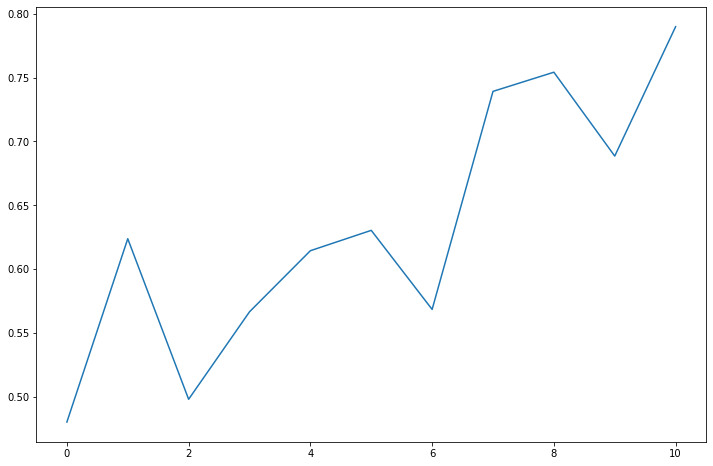

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(np.arange(num_queries+1), results)